In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from PIL import Image
from geopy.geocoders import Nominatim
import xarray as xr
import rasterio
from rasterio.plot import show

-3.451751519941929,-54.56393669442629



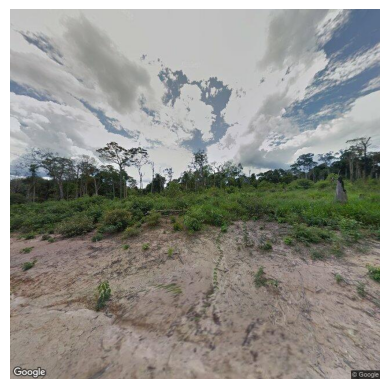

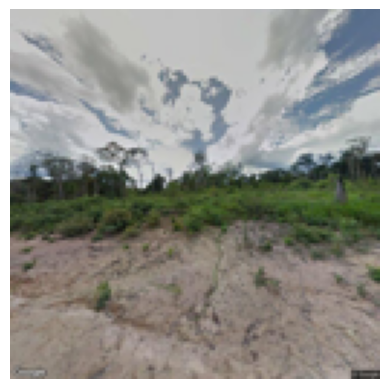

México


In [2]:
# Test loading an image
import csv

coords = list(open('../../database/csv_data/coords.csv'))
print(coords[1])

im = Image.open('../../database/dataset/1.png')
plt.imshow(im)
plt.axis('off')
plt.show()
im = im.resize((128, 128))
plt.imshow(im)
plt.axis('off')
plt.show()

geolocator = Nominatim(user_agent='MSU CSE 404 Project Application')
print(geolocator.reverse(coords[0]).raw['address']['country'])

In [7]:
# Load population density information

pop_ds = xr.load_dataset('2000total.nc', decode_coords="all").fillna(0)
rural_ds = xr.load_dataset('2000rurall.nc', decode_coords='all').fillna(0)
urban_ds = xr.load_dataset('2000urban.nc', decode_coords='all').fillna(0)

# take a sample in New York City
nyc = pop_ds.sel(lat = 40.673407, lon = -73.928872, method='nearest')['2000total'].data
nyc_rural = rural_ds.sel(lat = 40.673407, lon = -73.928872, method='nearest')['2000rural'].data
nyc_urban = urban_ds.sel(lat = 40.673407, lon = -73.928872, method='nearest')['2000urban'].data

# Take a sample in remote Mongolia
mongolia = pop_ds.sel(lat = 48.200962, lon = 98.625004, method='nearest')['2000total'].data

kwc = pop_ds.sel(lat = 22.332222, lon = 114.190278, method='nearest')['2000total'].data

middle_of_the_ocean = pop_ds.sel(lat = 31.748920919604693, lon = -40.1219493509592, method='nearest')['2000total'].data

print(mongolia, nyc, kwc, middle_of_the_ocean)
print(nyc_rural)
print(nyc_urban)

# It doesn't really seem to be that accurate, but it things are correct-ish relative to each other
# Might need to find a different dataset


210.0 2295220.0 3502260.0 0.0
0.0
2295220.0


In [13]:
# take a sample in New York City
nyc = pop_ds.sel(lat = 40.673407, lon = -73.928872, method='nearest')['2000total'].data

mongolia = pop_ds.sel(lat = 48.200962, lon = 98.625004, method='nearest')['2000total'].data

kwc = pop_ds.sel(lat = 22.332222, lon = 114.190278, method='nearest')['2000total'].data

middle_of_the_ocean = pop_ds.sel(lat = 31.748920919604693, lon = -40.1219493509592, method='nearest')['2000total'].data

print(mongolia, nyc, kwc, middle_of_the_ocean)

# It doesn't really seem to be that accurate, but it things are correct-ish relative to each other
# Might need to find a different dataset


210.0 2295220.0 3502260.0 0.0


In [58]:
# Iterate over the images
X = []
y = np.array([])
w = np.array([])
z = np.array([])

NUM_IMAGES=10000
for i, coord in enumerate(coords[:NUM_IMAGES]):
    print("Percent Complete: {}".format(100 * i / len(coords)))

    # Parse coordinate string
    lat, lon = coord.split(',')
    lat, lon = (float(lat), float(lon))

    # Load image data and flatten rgb sub-pixels
    image = Image.open('../../database/dataset/{}.png'.format(i))
    image = image.resize((128, 128))
    image = list(image.getdata())
    image = [item for sublist in image for item in sublist]
    X.append(np.array(image))
    
    # Grab populations
    urban_population = urban_ds.sel(lat = lat, lon = lon, method='nearest')['2000urban'].data
    rural_population = rural_ds.sel(lat = lat, lon = lon, method='nearest')['2000rural'].data
    

    z = np.append(z, np.array(urban_population))
    w = np.append(w, np.array(rural_population))
    y = np.append(y, np.array(int(urban_population > rural_population)))

X = np.vstack(X)

Percent Complete: 0.0
Percent Complete: 0.01
Percent Complete: 0.02
Percent Complete: 0.03
Percent Complete: 0.04
Percent Complete: 0.05
Percent Complete: 0.06
Percent Complete: 0.07
Percent Complete: 0.08
Percent Complete: 0.09
Percent Complete: 0.1
Percent Complete: 0.11
Percent Complete: 0.12
Percent Complete: 0.13
Percent Complete: 0.14
Percent Complete: 0.15
Percent Complete: 0.16
Percent Complete: 0.17
Percent Complete: 0.18
Percent Complete: 0.19
Percent Complete: 0.2
Percent Complete: 0.21
Percent Complete: 0.22
Percent Complete: 0.23
Percent Complete: 0.24
Percent Complete: 0.25
Percent Complete: 0.26
Percent Complete: 0.27
Percent Complete: 0.28
Percent Complete: 0.29
Percent Complete: 0.3
Percent Complete: 0.31
Percent Complete: 0.32
Percent Complete: 0.33
Percent Complete: 0.34
Percent Complete: 0.35
Percent Complete: 0.36
Percent Complete: 0.37
Percent Complete: 0.38
Percent Complete: 0.39
Percent Complete: 0.4
Percent Complete: 0.41
Percent Complete: 0.42
Percent Complete

In [59]:
print(X.shape, y.shape)

(10000, 49152) (10000,)


In [ ]:
import plotly.express as px
import pandas as pd

df = pd.read_csv('../../database/csv_data/coords.csv', names=["Latitude", "Longitude"])

df.dropna(
    axis=0,
    how='any',
    subset=None,
    inplace=True
)

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_map(df[:NUM_IMAGES], 
                        color_continuous_scale=color_scale,
                        color=y,
                        lat="Latitude",
                        lon="Longitude",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Index(['20.82488495242425', '-98.4995168750031'], dtype='object')


KeyError: 0

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

log_reg = LogisticRegression(solver="lbfgs", random_state=42, max_iter=10000)
log_reg.fit(X_train, y_train)
log_reg.coef_

array([[-0.00047614, -0.00070255, -0.00270908, ..., -0.00030205,
        -0.00117873, -0.00162262]])

In [63]:
from sklearn.metrics import accuracy_score
print("Train accuracy:", accuracy_score(y_train, log_reg.predict(X_train)))
print("Test accuracy:", accuracy_score(y_test, log_reg.predict(X_test)))

Train accuracy: 1.0
Test accuracy: 0.9075
